# Vorticity-based diagnostics

Vorticity is an omnipresent physical quantity in GFD. Here we show how to compute it from the model output:

In [1]:
%matplotlib inline

In [2]:
import xarray as xr
from xgcm import Grid
import numpy as np

In [3]:
dataurl = 'http://35.188.34.63:8080/thredds/dodsC/OM4p5/'

ds = xr.open_dataset(f'{dataurl}/ocean_monthly_z.200301-200712.nc4',
                     chunks={'time':1, 'z_l': 1}, engine='pydap')

A quick look at the coordinates in the dataset shows that the grid is saved in non-symetric mode (see https://mom6.readthedocs.io/en/dev-gfdl/api/generated/pages/Horizontal_indexing.html for details) and that the first vorticity point is located northeast of the first center point,
in agreement with the model's conventions.

In [4]:
ds

<xarray.Dataset>
Dimensions:       (nv: 2, time: 60, xh: 720, xq: 720, yh: 576, yq: 576, z_i: 36, z_l: 35)
Coordinates:
  * nv            (nv) float64 1.0 2.0
  * xh            (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * xq            (xq) float64 -299.5 -299.0 -298.5 -298.0 ... 59.0 59.5 60.0
  * yh            (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * yq            (yq) float64 -77.82 -77.63 -77.45 -77.26 ... 89.58 89.79 90.0
  * z_i           (z_i) float64 0.0 5.0 15.0 25.0 ... 5.75e+03 6.25e+03 6.75e+03
  * z_l           (z_l) float64 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
  * time          (time) object 2003-01-16 12:00:00 ... 2007-12-16 12:00:00
Data variables:
    Coriolis      (yq, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello     (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello_bu  (yq, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello_cu  (yh, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello_cv  (yq, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    deptho        (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    dxCu          (yh, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    dxCv          (yq, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    dxt           (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    dyCu          (yh, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    dyCv          (yq, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    dyt           (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolat        (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolat_c      (yq, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolat_u      (yh, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolat_v      (yq, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolon        (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolon_c      (yq, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolon_u      (yh, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolon_v      (yq, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    hfgeou        (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    sftof         (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    thkcello      (z_l, yh, xh) float32 dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
    wet           (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    wet_c         (yq, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    wet_u         (yh, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    wet_v         (yq, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    average_DT    (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T1    (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2    (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    so            (time, z_l, yh, xh) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    time_bnds     (time, nv) timedelta64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    thetao        (time, z_l, yh, xh) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    umo           (time, z_l, yh, xq) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    uo            (time, z_l, yh, xq) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    vmo           (time, z_l, yq, xh) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    vo            (time, z_l, yq, xh) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    volcello

We can then define our xgcm grid object (see https://xgcm.readthedocs.io/en/latest/ for details). Note that left/right is relative to the center point on a given axis, which means along Y up/down would translate to right/left. We also specify along which axes we need to apply periodic conditions.

In [5]:
grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])

In symetric mode, we would define the grid object as:

```python
grid = Grid(ds, coords={'X': {'inner': 'xh', 'outer': 'xq'},
                        'Y': {'inner': 'yh', 'outer': 'yq'} }, periodic=['X'])
```

## Relative vorticity

The expression for relative vorticity ($\zeta = \partial v / \partial x - \partial u / \partial y$) on the irregular grid translates to:

In [6]:
vorticity = ( - grid.diff(ds.uo * ds.dxCu, 'Y', boundary='fill') 
              + grid.diff(ds.vo * ds.dyCv, 'X', boundary='fill') ) / ds.areacello_bu

Since the formula is evaluated lazily, it takes less than a second and
since xgcm is aware of the labels, the resulting field has the right coordinates. 

In [7]:
vorticity

<xarray.DataArray (time: 60, z_l: 35, yq: 576, xq: 720)>
dask.array<truediv, shape=(60, 35, 576, 720), dtype=float32, chunksize=(1, 1, 575, 719), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2003-01-16 12:00:00 ... 2007-12-16 12:00:00
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * yq       (yq) float64 -77.82 -77.63 -77.45 -77.26 ... 89.37 89.58 89.79 90.0
  * xq       (xq) float64 -299.5 -299.0 -298.5 -298.0 ... 58.5 59.0 59.5 60.0

We can look at surface values for the last time frame for a visual check:

In [8]:
vort_plt = vorticity.sel(z_l=2.5, time='2004-12')
vort_plt.load() # so that we don't recompute each time we change the plot

<xarray.DataArray (time: 1, yq: 576, xq: 720)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) object 2004-12-16 12:00:00
    z_l      float64 2.5
  * yq       (yq) float64 -77.82 -77.63 -77.45 -77.26 ... 89.37 89.58 89.79 90.0
  * xq       (xq) float64 -299.5 -299.0 -298.5 -298.0 ... 58.5 59.0 59.5 60.0

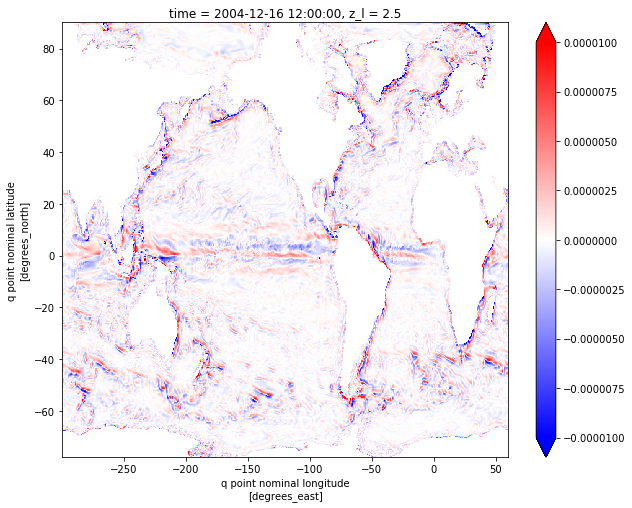

In [9]:
vort_plt.plot(figsize=[10,8], cmap='bwr', vmin=-1e-5, vmax=1e-5)

NB: This is plotted with the "nominal" longitude/latitude xq/yq. For true geographical coordinates, use geolon_c and geolat_c (grid corners).

## Potential vorticity $(\zeta + f) / h$

We need to interpolate deptho at the q-point (in 2 steps: first on U-point then on Q-point) and then this is pretty straightfoward:

In [10]:
depthu = grid.interp(ds.deptho, 'X', boundary='fill')
depthq = grid.interp(depthu, 'Y', boundary='fill')

Note that the resulting array has now the same labels for coordinates than vorticity:

In [11]:
depthq

<xarray.DataArray 'mul-2e41182f53703b7dfb6668570b3584a4' (yq: 576, xq: 720)>
dask.array<mul, shape=(576, 720), dtype=float32, chunksize=(575, 719), chunktype=numpy.ndarray>
Coordinates:
  * yq       (yq) float64 -77.82 -77.63 -77.45 -77.26 ... 89.37 89.58 89.79 90.0
  * xq       (xq) float64 -299.5 -299.0 -298.5 -298.0 ... 58.5 59.0 59.5 60.0

Consequently, xarray is going to recognize that arrays are co-located and perform operation:

In [12]:
pv = (vorticity + ds.Coriolis) / depthq

In [13]:
pv

<xarray.DataArray (time: 60, z_l: 35, yq: 576, xq: 720)>
dask.array<truediv, shape=(60, 35, 576, 720), dtype=float32, chunksize=(1, 1, 575, 719), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2003-01-16 12:00:00 ... 2007-12-16 12:00:00
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * yq       (yq) float64 -77.82 -77.63 -77.45 -77.26 ... 89.37 89.58 89.79 90.0
  * xq       (xq) float64 -299.5 -299.0 -298.5 -298.0 ... 58.5 59.0 59.5 60.0

In [14]:
pv_plt = pv.sel(z_l=2.5, time='2004-12')
pv_plt.load() # so that we don't recompute each time we change the plot

<xarray.DataArray (time: 1, yq: 576, xq: 720)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) object 2004-12-16 12:00:00
    z_l      float64 2.5
  * yq       (yq) float64 -77.82 -77.63 -77.45 -77.26 ... 89.37 89.58 89.79 90.0
  * xq       (xq) float64 -299.5 -299.0 -298.5 -298.0 ... 58.5 59.0 59.5 60.0

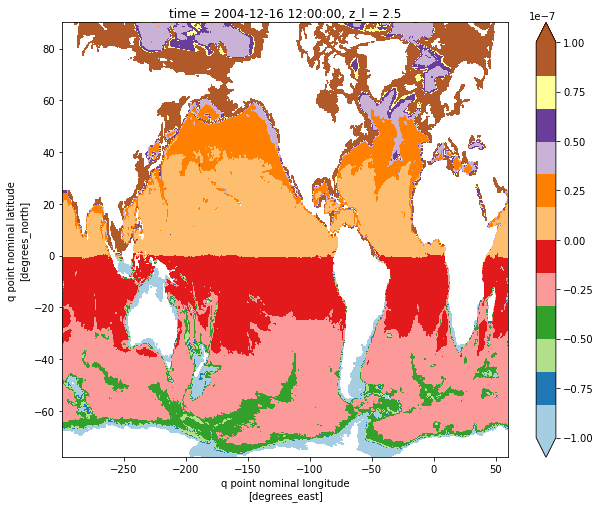

In [15]:
pv_plt.plot(figsize=[10,8], cmap='Paired', vmin=-1e-7, vmax=1e-7)